# Sentiment Analysis

### Loading imports

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

### Loading Dataset

In [4]:
# Load the IMDB reviews dataset into a pandas dataFrame
review_df = pd.read_csv('IMDB_reviews.csv')

### Dataset preview

In [5]:
# Print two rows of dataset
print("Print the first 2 rows of the dataset:")
print(review_df.head(2))

Print the first 2 rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive


## Data preprocessing:

### Cleaning and Standardization

In [6]:
def preprocess_corpus(corpus, modelType):
    """Process corpus function.
    Input:
        corpus: a string containing a review
    Output:
        corpus_clean: for Logistic Regression model the output is string, for Neural Network model the output is array of strings
    """

    # Remove <br /> tags with spaces
    corpus = re.sub(r"<br\s*\/?>", " ", corpus)

    # Remove non-alphanumeric characters, including single and double quotes
    corpus = re.sub(r"[^a-zA-Z0-9\s’'\"”“]", "", corpus)

    # remove hyperlinks
    corpus = re.sub(r'https?:\/\/.*[\r\n]*', '', corpus)

    # remove hashtags
    corpus = re.sub(r'#', '', corpus)

    # Convert text to lowercase
    corpus = corpus.lower()

    # Remove special characters and punctuation
    corpus = re.sub(f"[{string.punctuation}]", "", corpus)

    # Remove words that are purely digits
    words = corpus.split()  # Split the text into words
    filtered_words = [word for word in words if not word.isdigit()]

    # # Remove stopwords
    stop_words = set(stopwords.words("english"))

    if modelType == 0:
        filtered_words = [word for word in filtered_words if word not in stop_words]
        preprocessed_text = " ".join(filtered_words)
        return preprocessed_text
    elif modelType == 1:
        words = [word for word in words if not word.isdigit() and word not in stop_words]
        return words

### Label Encoding

In [7]:
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(review_df['sentiment'])

#### Save data to a new file

In [48]:
# # Save the preprocessed DataFrame to a new CSV file
# preprocessed_file_path = 'preprocessed_reviews.csv'
# review_df.to_csv(preprocessed_file_path, index=False)

### Tokenization and padding

In [8]:
def tokenize_padding():
    tokenizer = Tokenizer(lower=False)
    tokenizer.fit_on_texts(x_train)

    train_sequences = tokenizer.texts_to_sequences(x_train)
    test_sequences = tokenizer.texts_to_sequences(x_test)
    max_length = get_max_length()

    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    total_words = len(tokenizer.word_index) + 1   # add 1 because of 0 padding
    return train_padded_sequences, test_padded_sequences, total_words, max_length

In [9]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

# Learning Models

## Logistic Regression

### Data Splitting for Model Training

In [10]:
x_data = review_df['review']
x_data = x_data.apply(lambda review: preprocess_corpus(review, 0))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)

### TF-IDF Vectorization

In [11]:
# Initialize TfidfVectorization
vectorized = TfidfVectorizer(max_features=10000)
train_vectors = vectorized.fit_transform(x_train)
test_vectors = vectorized.transform(x_test)

### Training Model

In [12]:
# Initialize and train Logistic Regression model
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(train_vectors, y_train)

# Predict on the train and test data
train_predictions = LR_model.predict(train_vectors)
test_predictions = LR_model.predict(test_vectors)

### Evaluation

Train accuracy: 0.50296
Test accuracy: 0.50368
Confusion Matrix (Test Set):
 [[3260 2932]
 [3272 3036]]


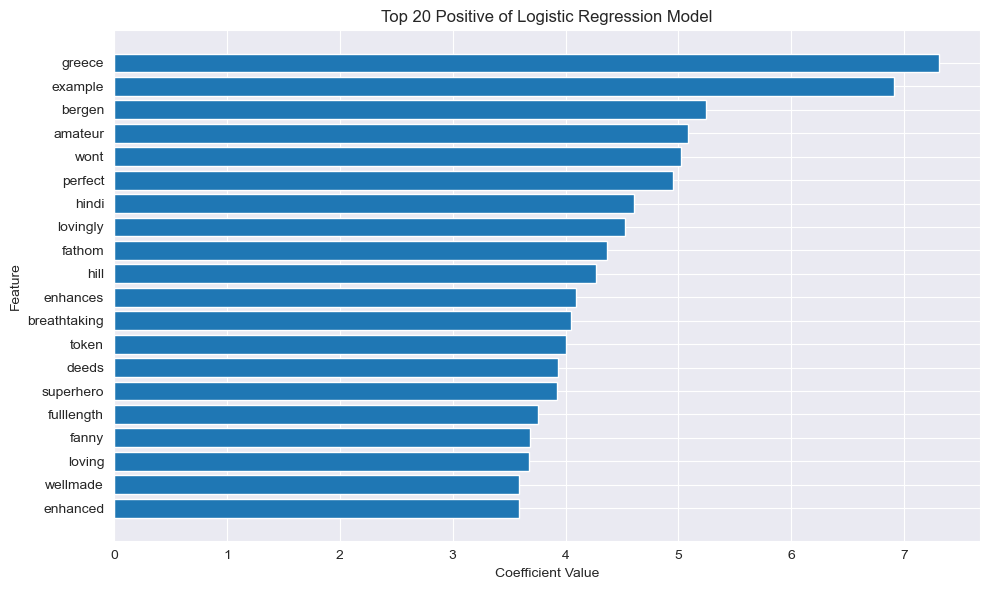

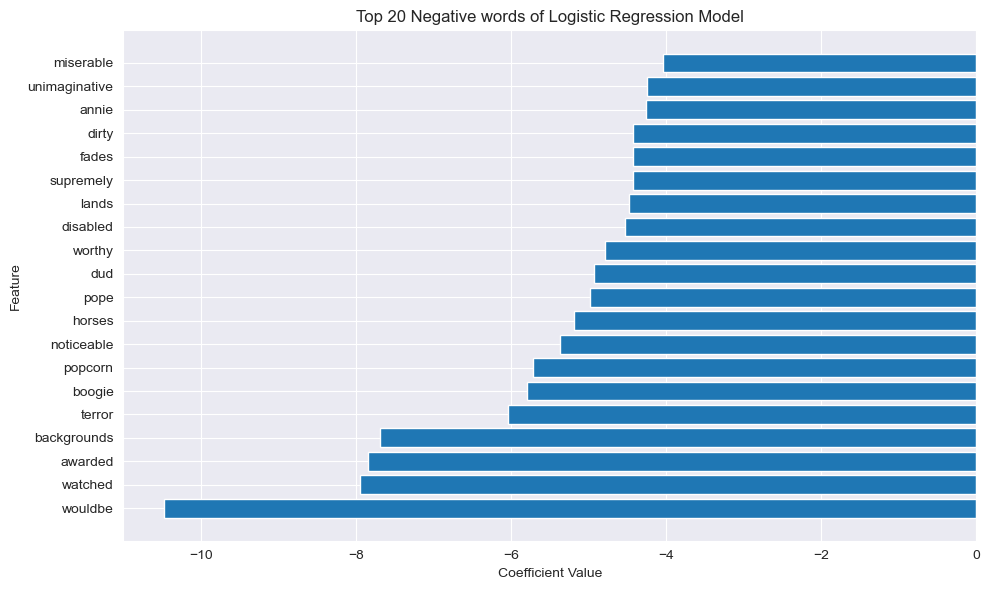

In [35]:
# Calculate accuracy
LR_train_accuracy = accuracy_score(y_train, train_predictions)
print("Train accuracy:", LR_train_accuracy)

LR_test_accuracy = accuracy_score(y_test, test_predictions)
print("Test accuracy:", LR_test_accuracy)

# Calculate confusion
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test Set):\n", test_confusion_matrix)

# Get feature names and coefficients
feature_names = vectorized.get_feature_names_out()
coefficients = LR_model.coef_[0]

# Sort coefficients by magnitude
sorted_indices = np.argsort(coefficients)
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Positive words
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[-20:], sorted_coefficients[-20:])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Positive of Logistic Regression Model')
plt.tight_layout()
plt.show()

# Negative words
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:20], sorted_coefficients[:20])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Negative words of Logistic Regression Model')
plt.tight_layout()
plt.show()

## LSTM Neural Network

### Get tokenized and padded data

In [22]:
x_data = review_df['review']
x_data = x_data.apply(lambda review: preprocess_corpus(review, 1))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)

train_padded_sequences, test_padded_sequences, total_words, max_length = tokenize_padding()

### Training model

In [23]:
def create_LSTM_model(embed_dim, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(total_words, embed_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(lstm_units))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
    return model

### Grid Search

In [58]:
LSTM_NN_model = KerasClassifier(build_fn=create_LSTM_model, epochs=5, batch_size=128)
# Define the hyperparameter grid
param_grid = {
    'embed_dim': [32, 64],
    'lstm_units': [64, 128],
    'dense_units': [64, 128],
    'dropout_rate': [0.2, 0.5]
}
# Perform Grid Search
grid = GridSearchCV(estimator=LSTM_NN_model, param_grid=param_grid, cv=3, verbose=5)
grid_result = grid.fit(train_padded_sequences, y_train)

C:\Users\Hooman\AppData\Local\Temp\ipykernel_21464\2262279617.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  LSTM_NN_model = KerasClassifier(build_fn=create_LSTM_model, epochs=5, batch_size=128)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/5
196/196 [==============================] - 21s 93ms/step - loss: 0.6363 - accuracy: 0.5923
Epoch 2/5
196/196 [==============================] - 18s 93ms/step - loss: 0.2862 - accuracy: 0.8887
Epoch 3/5
196/196 [==============================] - 18s 89ms/step - loss: 0.1289 - accuracy: 0.9584
Epoch 4/5
196/196 [==============================] - 18s 91ms/step - loss: 0.0654 - accuracy: 0.9808
Epoch 5/5
98/98 [==============================] - 3s 27ms/step - loss: 0.7318 - accuracy: 0.8590
[CV 1/3] END dense_units=64, dropout_rate=0.2, embed_dim=32, lstm_units=64;, score=0.859 total time= 1.6min
Epoch 1/5
196/196 [==============================] - 20s 91ms/step - loss: 0.5856 - accuracy: 0.6374
Epoch 2/5
196/196 [==============================] - 18s 90ms/step - loss: 0.2491 - accuracy: 0.9062
Epoch 3/5
196/196 [==============================] - 18s 90ms/step - loss: 0.1108 - accuracy: 0.9646
Epoch 4/5
196/196 [=======

#### Add to Excel file

In [59]:
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('LSTM_NN_model.csv', index=False)

### Evaluation

#### Train with best parameters

Epoch 1/5
293/293 [==============================] - 32s 100ms/step - loss: 0.5228 - accuracy: 0.6997
Epoch 2/5
293/293 [==============================] - 29s 100ms/step - loss: 0.2270 - accuracy: 0.9165
Epoch 3/5
293/293 [==============================] - 28s 95ms/step - loss: 0.1119 - accuracy: 0.9645
Epoch 4/5
293/293 [==============================] - 28s 95ms/step - loss: 0.0612 - accuracy: 0.9821
Epoch 5/5
391/391 [==============================] - 6s 14ms/step
Train precision: 0.9979572089022686
Train recall: 0.9854026222198631
Train F1-score: 0.9916401805507332
Train Accuracy: 0.9916533333333334
Test precision: 0.8780695770804912
Test recall: 0.8357409511442948
Test F1-score: 0.8563825363825365
Test accuracy: 0.86184


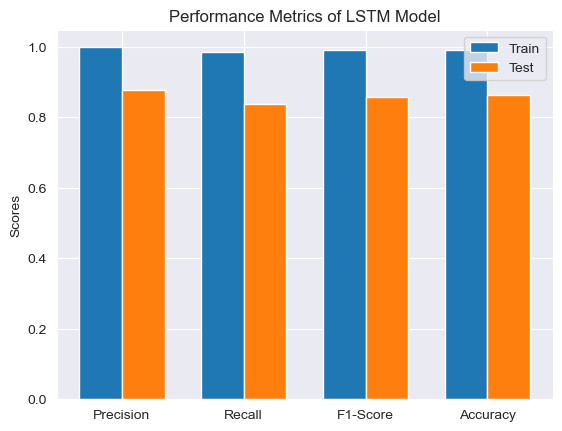

In [25]:
LSTM_NN_model = create_LSTM_model(32,64,64,0.5)
# early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
LSTM_NN_model.fit(train_padded_sequences, y_train, epochs=5, batch_size=128)

# Evaluate the model on the train set
train_predictions = LSTM_NN_model.predict(train_padded_sequences)
train_predictions = np.round(train_predictions).astype(int)

# Evaluate the model on the test set
test_predictions = LSTM_NN_model.predict(test_padded_sequences)
test_predictions = np.round(test_predictions).astype(int)

train_precision = precision_score(y_train, train_predictions)
print("Train precision:", train_precision)

# Calculate recall
train_recall = recall_score(y_train, train_predictions)
print("Train recall:", train_recall)

# Calculate F1-score
train_f1 = f1_score(y_train, train_predictions)
print("Train F1-score:", train_f1)

LSTM_NN_train_accuracy = accuracy_score(y_train, train_predictions)
print("Train Accuracy:", LSTM_NN_train_accuracy)


test_precision = precision_score(y_test, test_predictions)
print("Test precision:", test_precision)

# Calculate recall
test_recall = recall_score(y_test, test_predictions)
print("Test recall:", test_recall)

# Calculate F1-score
test_f1 = f1_score(y_test, test_predictions)
print("Test F1-score:", test_f1)

LSTM_NN_test_accuracy = accuracy_score(y_test, test_predictions)
print("Test accuracy:", LSTM_NN_test_accuracy)
# print(LSTM_NN_model.summary())

# Metrics for train and test sets
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
train_values = [train_precision, train_recall, train_f1, LSTM_NN_train_accuracy]
test_values = [test_precision, test_recall, test_f1, LSTM_NN_test_accuracy]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_values, width, label='Train')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of LSTM Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

## Naive Bayes

### Data Splitting

In [26]:
x_data = review_df['review']
x_data = x_data.apply(lambda review: preprocess_corpus(review, 0))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)

### Count Vectorization

In [27]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(x_train)
x_test_count = vectorizer.transform(x_test)

### Training model

In [ ]:
# Initialize the Multinomial Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(x_train_count, y_train)

### Evaluation

Training Accuracy: 0.50296
Training Confusion Matrix:
 [[9925 8883]
 [9756 8936]]

Test Accuracy: 0.50368
Test Confusion Matrix:
 [[3260 2932]
 [3272 3036]]


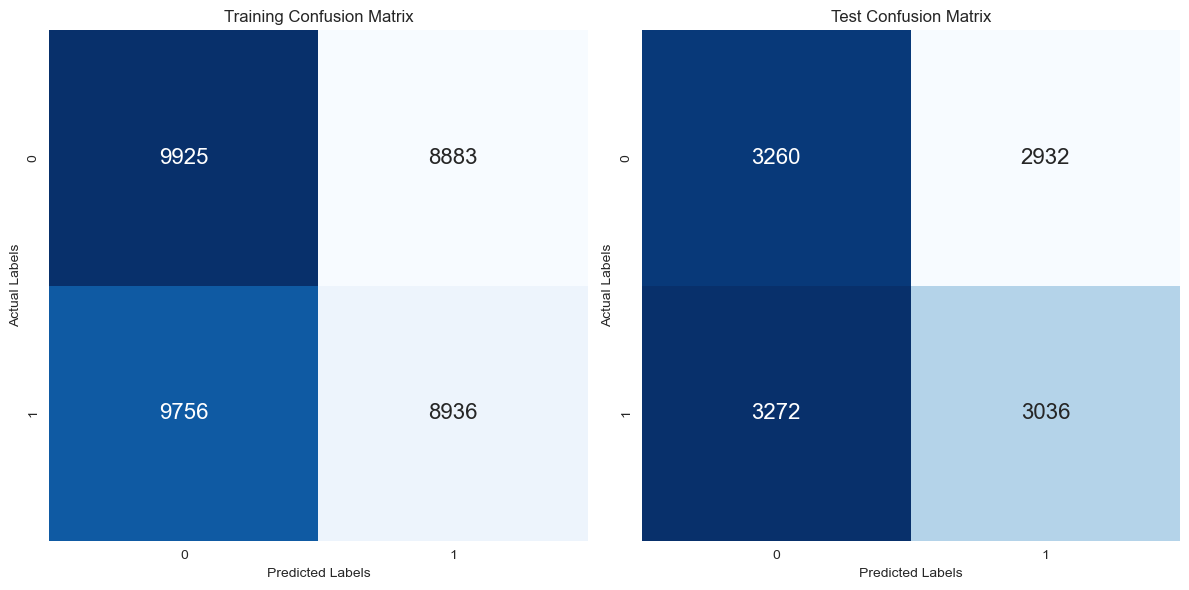

In [36]:
train_predictions = NB_model.predict(x_train_count)
NB_train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", NB_train_accuracy)
train_confusion_matrix = confusion_matrix(y_train, train_predictions)
print("Training Confusion Matrix:\n", train_confusion_matrix)

test_predictions = NB_model.predict(x_test_count)
NB_test_accuracy = accuracy_score(y_test, test_predictions)
print("\nTest Accuracy:", NB_test_accuracy)
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(train_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            ax=axes[0], annot_kws={"size": 16})
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("Actual Labels")

sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            ax=axes[1], annot_kws={"size": 16})
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("Actual Labels")

plt.tight_layout()
plt.show()

## Clustering

### Data Splitting for Model Training

In [32]:
x_data = review_df['review']
x_data = x_data.apply(lambda review: preprocess_corpus(review, 0))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)

### TF-IDF Vectorization

In [33]:
# Initialize TfidfVectorization
vectorized = TfidfVectorizer(max_features=10000)
train_vectors = vectorized.fit_transform(x_data)
test_vectors = vectorized.transform(x_test)

### K-means

In [39]:
num_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(train_vectors)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
# Create a DataFrame to store reviews and their corresponding labels and clusters
review_labels_clusters_df = pd.DataFrame({'Review': x_data, 'Label': y_data, 'Cluster': clusters})

# Analyze whether reviews in the same cluster tend to have similar labels
cluster_label_analysis = review_labels_clusters_df.groupby(['Cluster', 'Label']).size().reset_index(name='Count')
print(cluster_label_analysis)

   Cluster  Label  Count
0        0      0   4104
1        0      1   5387
2        1      0   4338
3        1      1   4217
4        2      0    999
5        2      1   1502
6        3      0   8233
7        3      1  12636
8        4      0   7326
9        4      1   1258


### Clustering chart

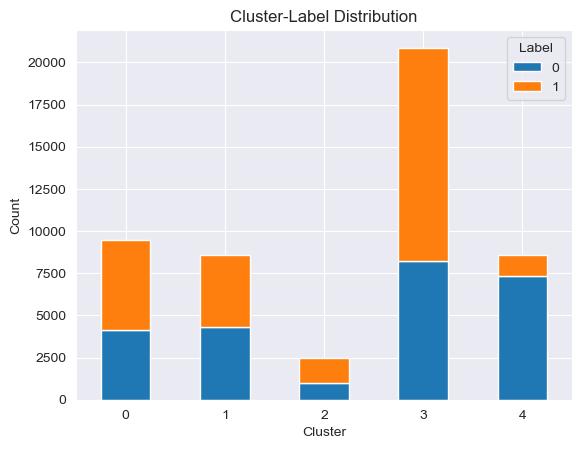

In [41]:
pivot_df = cluster_label_analysis.pivot(index='Cluster', columns='Label', values='Count')
pivot_df.fillna(0, inplace=True)

pivot_df.plot(kind='bar', stacked=True)
plt.title('Cluster-Label Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()

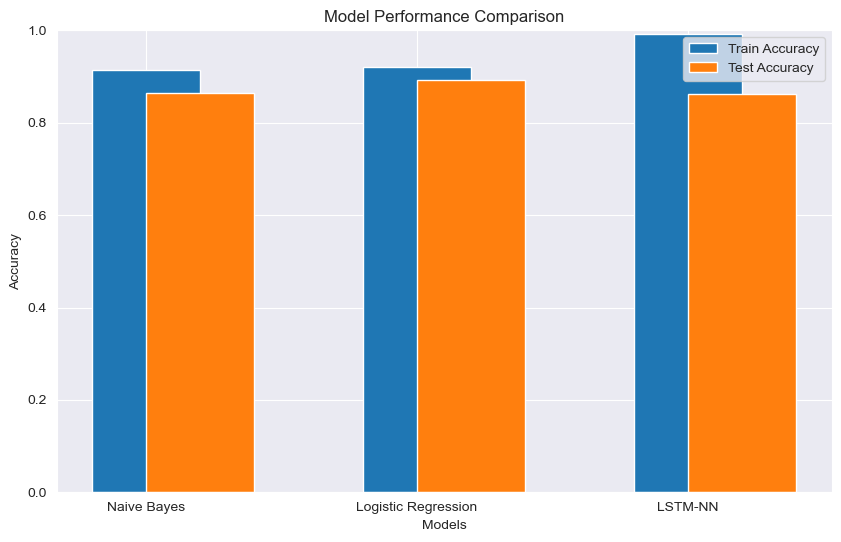

In [34]:
model_names = ['Naive Bayes', 'Logistic Regression', 'LSTM-NN']

# Accuracy values for training and test sets
train_accuracies = [NB_train_accuracy, LR_train_accuracy, LSTM_NN_train_accuracy]
test_accuracies = [NB_test_accuracy, LR_test_accuracy, LSTM_NN_test_accuracy]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_accuracies, width=0.4, label='Train Accuracy')
plt.bar(model_names, test_accuracies, width=0.4, align='edge', label='Test Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.ylim(0, 1)

plt.show()